# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 1, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)        
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 3, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 11
[[0], [1], [2], [3], [4], [5], [-1], [-2], [-3], [-4], [-5]]


  0%|          | 0/11 [00:00<?, ?it/s]

List length: 11
[[0], [1], [2], [3], [4], [5], [-1], [-2], [-3], [-4], [-5]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_36_drop0.25e500b256_custom/lnets_10000_55-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_laurent_spars_11_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_10000_55-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_laurent_spars_11_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:   11.5s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,-1-target,-2-target,-3-target,-4-target,-5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,-1-lstsq_lambda,-2-lstsq_lambda,-3-lstsq_lambda,-4-lstsq_lambda,-5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,-1-lstsq_target,-2-lstsq_target,-3-lstsq_target,-4-lstsq_target,-5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165
6252,1373158606,-0.458,0.913,-0.568,-0.116,-0.640,0.750,-0.557,-0.931,-0.922,-0.172,0.046,-0.460,-3.657,4.681,-6.702,5.066,-1.529,-0.075,0.007,-0.000,0.000,-0.000,-0.454,0.859,-0.315,-0.625,-0.180,0.597,-0.557,-0.931,-0.922,-0.172,0.046,-0.007,-0.169,0.355,0.276,0.086,0.061,0.332,-0.221,0.251,0.401,0.454,-0.066,-0.014,0.364,0.060,0.438,0.004,0.145,0.134,0.134,0.023,0.213,0.191,-0.031,-0.300,-0.067,0.220,-0.217,-0.155,-0.173,0.083,0.231,0.092,0.392,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.057,0.298,0.449,-0.147,0.425,0.252,0.209,0.460,0.153,-0.301,-0.029,0.305,-0.288,-0.066,-0.245,0.000,0.000,0.143,0.143,-0.083,-0.064,0.153,0.000,0.142,0.176,0.150,0.000,0.000,0.150,-0.062,0.145,-0.020,-0.067,-0.101,-0.087,-0.033,0.143,0.166,0.000,0.000,0.000,0.142,0.000,0.000,0.000,-0.083,-0.056,-0.089,0.148,0.000,0.000,0.000,0.000,0.000,0.000,-0.061,0.125,0.166,0.000,0.164,0.145,0.183,0.147,-0.107,0.000,0.000,0.184,0.000,0.000,0.000,-0.189,-0.267,-0.373,-0.373,0.103,0.138,-0.257,-0.303,-0.393,-0.173,-0.271,-0.262,-0.271,-0.267,0.090,-0.328,0.291,-0.009,0.115,0.025,0.034,-0.427,-0.229,-0.194,-0.285,-0.044,-0.446,0.107,-0.192,-0.234,0.213,-0.028,0.163,-0.297,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.085,-0.137,-0.192,0.011,-0.199,-0.370,-0.192,-0.297,0.185,-0.050,0.036,-0.168,0.173,0.082,0.183,-0.130
4684,1373158606,0.460,-0.493,-0.972,0.388,0.818,0.595,0.245,0.955,-0.134,0.050,-0.975,-0.654,0.666,-1.845,1.846,-1.042,0.255,0.085,-0.008,0.000,-0.000,0.000,0.478,-0.478,-1.113,0.418,1.056,0.433,0.243,0.955,-0.134,0.050,-0.975,-0.007,-0.169,0.253,0.174,0.137,0.091,0.221,-0.221,0.150,0.271,0.346,-0.066,-0.014,0.255,0.089,0.334,0.005,0.174,0.200,0.186,0.032,0.112,0.069,-0.031,-0.300,-0.067,0.120,-0.217,-0.155,-0.173,0.133,0.247,0.148,0.286,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.084,0.153,0.327,-0.147,0.304,0.149,0.074,0.354,0.225,-0.301,-0.029,0.166,-0.288,-0.066,-0.245,0.000,0.000,0.044,0.044,-0.039,-0.038,0.045,0.000,0.044,0.048,0.045,0.000,0.000,0.044,-0.037,0.044,-0.018,-0.038,-0.040,-0.039,-0.026,0.044,0.047,0.000,0.000,0.000,0.044,0.000,0.000,0.000,-0.039,-0.038,-0.040,0.044,0.000,0.000,0.000,0.000,0.000,0.000,-0.037,-0.019,0.046,0.000,0.046,0.044,0.050,0.044,-0.041,0.000,0.000,0.048,0.000,0.000,0.000,-0.189,-0.267,-0.263,-0.258,0.129,0.152,-0.144,-0.303,-0.276,-0.061,-0.164,-0.262,-0.271,-0.157,0.104,-0.221,0.293,0.040,0.156,0.069,0.040,-0.305,-0.097,-0.194,-0.285,-0.044,-0.325,0.107,-0.192,-0.234,0.237,0.038,0.190,-0.188,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,-1-target,-2-target,-3-target,-4-target,-5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,-1-lstsq_lambda,-2-lstsq_lambda,-3-lstsq_lambda,-4-lstsq_lambda,-5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,-1-lstsq_target,-2-lstsq_target,-3-lstsq_target,-4-lstsq_target,-5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,0.002,0.002,0.000,-0.009,-0.005,0.004,-0.001,-0.008,-0.000,-0.000,0.005,43.545,-143.357,280.549,-318.600,193.009,-48.163,-7.865,0.855,-0.054,0.002,-0.000,0.002,0.002,-0.001,-0.004,-0.010,0.006,-0.001,-0.008,-0.000,-0.000,0.005,-0.007,-0.169,0.208,0.128,0.167,0.119,0.176,-0.221,0.104,0.226,0.303,-0.066,-0.014,0.212,0.117,0.293,0.023,0.198,0.233,0.218,0.053,0.066,0.029,-0.031,-0.300,-0.067,0.074,-0.217,-0.155,-0.173,0.164,0.274,0.182,0.241,-0.061,-0.254,-0.227,-0.012,-0

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.05086599],
       [0.55975996],
       [0.41274214],
       [0.47257254],
       [0.5075179 ],
       [0.36094887],
       [0.48352383],
       [0.91640914],
       [0.27338251],
       [0.88157451]])

In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 1.00638402e+05],
       [-1.03168255e+01],
       [-2.22617606e+01],
       [-1.57877780e+01],
       [-1.31839040e+01],
       [-3.12343343e+01],
       [-1.48982433e+01],
       [-3.24246464e+00],
       [-6.09222538e+01],
       [-3.53636510e+00]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8910, 200)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(990, 200)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 200)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,-1-target,-2-target,-3-target,-4-target,-5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,-1-lstsq_lambda,-2-lstsq_lambda,-3-lstsq_lambda,-4-lstsq_lambda,-5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,-1-lstsq_target,-2-lstsq_target,-3-lstsq_target,-4-lstsq_target,-5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165
5548,1373158606,0.469,0.792,0.086,-0.666,0.696,0.148,0.517,0.317,-0.878,-0.662,-0.428,-0.675,0.751,-2.104,2.243,-1.347,0.345,0.088,-0.009,0.001,-0.000,0.000,0.468,0.923,-0.456,0.063,0.394,0.124,0.516,0.317,-0.878,-0.662,-0.428,-0.007,-0.169,0.254,0.175,0.135,0.090,0.222,-0.221,0.151,0.272,0.347,-0.066,-0.014,0.257,0.088,0.335,0.004,0.174,0.199,0.185,0.028,0.112,0.069,-0.031,-0.300,-0.067,0.121,-0.217,-0.155,-0.173,0.132,0.247,0.147,0.286,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.083,0.153,0.328,-0.147,0.305,0.149,0.075,0.355,0.224,-0.301,-0.029,0.166,-0.288,-0.066,-0.245,0.000,0.000,0.044,0.044,-0.040,-0.039,0.045,0.000,0.044,0.048,0.045,0.000,0.000,0.045,-0.038,0.044,-0.019,-0.038,-0.041,-0.039,-0.028,0.044,0.046,0.000,0.000,0.000,0.044,0.000,0.000,0.000,-0.040,-0.038,-0.040,0.044,0.000,0.000,0.000,0.000,0.000,0.000,-0.038,-0.018,0.046,0.000,0.046,0.044,0.050,0.044,-0.041,0.000,0.000,0.048,0.000,0.000,0.000,-0.189,-0.267,-0.264,-0.258,0.126,0.150,-0.144,-0.303,-0.276,-0.061,-0.164,-0.262,-0.271,-0.158,0.101,-0.221,0.291,0.038,0.155,0.067,0.036,-0.305,-0.097,-0.194,-0.285,-0.044,-0.325,0.107,-0.192,-0.234,0.235,0.037,0.189,-0.188,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.096,-0.016,-0.083,0.011,-0.089,-0.252,-0.059,-0.191,0.229,-0.050,0.036,-0.046,0.173,0.082,0.183,-0.043
1854,1373158606,-0.927,-0.128,-0.765,-0.166,0.678,0.246,0.474,-0.302,0.889,0.419,-0.156,0.999,-2.614,6.793,-8.685,5.791,-1.565,-0.125,0.011,-0.001,0.000,-0.000,-0.928,-0.103,-0.869,0.018,0.520,0.301,0.473,-0.302,0.889,0.419,-0.156,-0.007,-0.169,0.171,0.093,0.217,0.171,0.139,-0.221,0.069,0.218,0.264,-0.066,-0.014,0.174,0.168,0.253,0.066,0.254,0.281,0.266,0.101,0.035,0.004,-0.031,-0.300,-0.067,0.042,-0.217,-0.155,-0.173,0.214,0.327,0.229,0.205,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.164,0.218,0.251,-0.147,0.226,0.067,0.012,0.272,0.306,-0.301,-0.029,0.168,-0.288,-0.066,-0.245,0.000,0.000,-0.042,-0.042,0.040,0.041,-0.042,0.000,-0.041,-0.006,-0.040,0.000,0.000,-0.041,0.041,-0.041,0.041,0.042,0.041,0.042,0.043,-0.035,-0.020,0.000,0.000,0.000,-0.037,0.000,0.000,0.000,0.041,0.042,0.041,-0.040,0.000,0.000,0.000,0.000,0.000,0.000,0.041,0.044,-0.033,0.000,-0.035,-0.041,-0.014,-0.041,0.040,0.000,0.000,0.048,0.000,0.000,0.000,-0.189,-0.267,-0.181,-0.179,0.205,0.227,-0.062,-0.303,-0.198,0.023,-0.081,-0.262,-0.271,-0.076,0.178,-0.139,0.354,0.118,0.235,0.148,0.106,-0.230,-0.031,-0.194,-0.285,-0.044,-0.250,0.107,-0.192,-0.234,0.314,0.117,0.268,-0.106,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.173,0

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,-1-target,-2-target,-3-target,-4-target,-5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,-1-lstsq_lambda,-2-lstsq_lambda,-3-lstsq_lambda,-4-lstsq_lambda,-5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,-1-lstsq_target,-2-lstsq_target,-3-lstsq_target,-4-lstsq_target,-5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165
4197,1373158606,0.618,-0.876,0.669,-0.450,-0.008,-0.238,0.141,0.592,0.979,-0.388,0.108,1.182,-3.133,7.878,-9.928,6.547,-1.750,-0.155,0.014,-0.001,0.000,-0.000,0.615,-0.840,0.495,-0.058,-0.408,-0.088,0.141,0.592,0.979,-0.388,0.108,-0.007,-0.169,0.169,0.091,0.221,0.174,0.137,-0.221,0.067,0.222,0.262,-0.066,-0.014,0.172,0.172,0.250,0.069,0.258,0.285,0.270,0.104,0.032,0.004,-0.031,-0.300,-0.067,0.039,-0.217,-0.155,-0.173,0.217,0.331,0.233,0.202,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.167,0.221,0.249,-0.147,0.224,0.065,0.031,0.270,0.310,-0.301,-0.029,0.170,-0.288,-0.066,-0.245,0.000,0.000,-0.042,-0.040,0.045,0.045,-0.040,0.000,-0.039,-0.003,-0.041,0.000,0.000,-0.040,0.045,-0.042,0.045,0.046,0.045,0.046,0.047,-0.035,-0.019,0.000,0.000,0.000,-0.037,0.000,0.000,0.000,0.045,0.046,0.045,-0.041,0.000,0.000,0.000,0.000,0.000,0.000,0.045,0.049,-0.033,0.000,-0.035,-0.039,0.002,-0.042,0.045,0.000,0.000,0.051,0.000,0.000,0.000,-0.189,-0.267,-0.179,-0.176,0.209,0.231,-0.059,-0.303,-0.195,0.025,-0.079,-0.262,-0.271,-0.073,0.182,-0.136,0.357,0.122,0.239,0.151,0.109,-0.229,-0.031,-0.194,-0.285,-0.044,-0.248,0.107,-0.192,-0.234,0.318,0.121,0.272,-0.103,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.177,0.069,0.002,0.011,-0.003,-0.171,0.016,-0.105,0.313,-0.050,0.036,0.048,0.173,0.082,0.183,0.044
5318,1373158606,-0.924,-0.044,-0.099,-0.878,-0.475,-0.511,-0.407,0.282,0.394,-0.322,0.576,0.464,-1.087,4.368,-6.815,5.194,-1.539,-0.014,-0.002,0.000,-0.000,0.000,-0.915,-0.096,-0.054,-0.697,-0.798,-0.366,-0.407,0.282,0.394,-0.322,0.576,-0.007,-0.169,0.175,0.099,0.214,0.168,0.143,-0.221,0.077,0.213,0.266,-0.066,-0.014,0.178,0.166,0.256,0.063,0.250,0.279,0.262,0.098,0.050,0.029,-0.031,-0.300,-0.067,0.055,-0.217,-0.155,-0.173,0.211,0.322,0.226,0.206,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.160,0.215,0.251,-0.147,0.227,0.074,0.030,0.275,0.304,-0.301,-0.029,0.163,-0.288,-0.066,-0.245,0.000,0.000,-0.039,-0.037,0.043,0.044,-0.038,0.000,-0.035,-0.010,-0.040,0.000,0.000,-0.039,0.044,-0.040,0.043,0.044,0.044,0.044,0.045,-0.028,-0.014,0.000,0.000,0.000,-0.030,0.000,0.000,0.000,0.044,0.045,0.043,-0.040,0.000,0.000,0.000,0.000,0.000,0.000,0.044,0.048,-0.033,0.000,-0.035,-0.035,-0.015,-0.040,0.044,0.000,0.000,0.050,0.000,0.000,0.000,-0.189,-0.267,-0.191,-0.192,0.206,0.228,-0.072,-0.303,-0.212,0.015,-0.087,-0.262,-0.271,-0.085,0.179,-0.147,0.356,0.117,0.235,0.147,0.107,-0.251,-0.061,-0.194,-0.285,-0.044,-0.270,0.107,-0.192,-0.234,0.314,0.115,0.269,-0.111,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.1

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,-1-target,-2-target,-3-target,-4-target,-5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,-1-lstsq_lambda,-2-lstsq_lambda,-3-lstsq_lambda,-4-lstsq_lambda,-5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,-1-lstsq_target,-2-lstsq_target,-3-lstsq_target,-4-lstsq_target,-5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90,wb_91,wb_92,wb_93,wb_94,wb_95,wb_96,wb_97,wb_98,wb_99,wb_100,wb_101,wb_102,wb_103,wb_104,wb_105,wb_106,wb_107,wb_108,wb_109,wb_110,wb_111,wb_112,wb_113,wb_114,wb_115,wb_116,wb_117,wb_118,wb_119,wb_120,wb_121,wb_122,wb_123,wb_124,wb_125,wb_126,wb_127,wb_128,wb_129,wb_130,wb_131,wb_132,wb_133,wb_134,wb_135,wb_136,wb_137,wb_138,wb_139,wb_140,wb_141,wb_142,wb_143,wb_144,wb_145,wb_146,wb_147,wb_148,wb_149,wb_150,wb_151,wb_152,wb_153,wb_154,wb_155,wb_156,wb_157,wb_158,wb_159,wb_160,wb_161,wb_162,wb_163,wb_164,wb_165
7217,1373158606,0.532,-0.389,-0.323,0.505,0.357,-0.584,0.654,0.569,0.595,-0.059,-0.343,0.021,-0.463,2.079,-2.721,1.836,-0.500,-0.011,-0.002,0.000,-0.000,0.000,0.534,-0.407,-0.278,0.474,0.348,-0.571,0.654,0.569,0.595,-0.059,-0.343,-0.007,-0.169,0.169,0.091,0.219,0.173,0.137,-0.221,0.067,0.222,0.263,-0.066,-0.014,0.173,0.170,0.251,0.068,0.255,0.282,0.268,0.102,0.027,-0.018,-0.031,-0.300,-0.067,0.037,-0.217,-0.155,-0.173,0.216,0.329,0.231,0.202,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.166,0.219,0.249,-0.147,0.224,0.065,0.039,0.270,0.308,-0.301,-0.029,0.166,-0.288,-0.066,-0.245,0.000,0.000,0.033,0.033,-0.025,-0.022,0.032,0.000,0.033,0.009,0.033,0.000,0.000,0.032,-0.023,0.032,-0.009,-0.025,-0.027,-0.026,-0.012,0.034,0.033,0.000,0.000,0.000,0.033,0.000,0.000,0.000,-0.025,-0.031,-0.024,0.034,0.000,0.000,0.000,0.000,0.000,0.000,-0.022,-0.024,0.027,0.000,0.028,0.033,-0.003,0.033,-0.027,0.000,0.000,-0.022,0.000,0.000,0.000,-0.189,-0.267,-0.178,-0.175,0.207,0.229,-0.059,-0.303,-0.194,0.024,-0.080,-0.262,-0.271,-0.074,0.179,-0.137,0.355,0.119,0.235,0.149,0.106,-0.227,-0.052,-0.194,-0.285,-0.044,-0.246,0.107,-0.192,-0.234,0.315,0.119,0.269,-0.104,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.174,0.066,0.001,0.011,-0.004,-0.170,0.022,-0.106,0.311,-0.050,0.036,0.044,0.173,0.082,0.183,-0.034
8291,1373158606,0.146,0.574,0.187,-0.245,-0.010,-0.717,-0.379,-0.955,-0.188,-0.818,0.321,-0.982,1.803,-4.443,5.172,-3.254,0.845,0.146,-0.015,0.001,-0.000,0.000,0.146,0.586,0.104,-0.033,-0.252,-0.614,-0.379,-0.955,-0.188,-0.818,0.321,-0.007,-0.169,0.256,0.177,0.133,0.086,0.224,-0.221,0.153,0.274,0.349,-0.066,-0.014,0.259,0.084,0.337,0.003,0.171,0.197,0.182,0.025,0.114,0.071,-0.031,-0.300,-0.067,0.123,-0.217,-0.155,-0.173,0.129,0.245,0.144,0.288,-0.061,-0.254,-0.227,-0.012,-0.164,-0.196,0.079,0.156,0.330,-0.147,0.307,0.151,0.076,0.357,0.222,-0.301,-0.029,0.167,-0.288,-0.066,-0.245,0.000,0.000,0.043,0.043,-0.045,-0.046,0.044,0.000,0.043,0.047,0.044,0.000,0.000,0.044,-0.045,0.043,-0.021,-0.042,-0.044,-0.043,-0.033,0.043,0.045,0.000,0.000,0.000,0.043,0.000,0.000,0.000,-0.045,-0.041,-0.045,0.043,0.000,0.000,0.000,0.000,0.000,0.000,-0.045,-0.016,0.045,0.000,0.046,0.043,0.048,0.044,-0.044,0.000,0.000,0.046,0.000,0.000,0.000,-0.189,-0.267,-0.264,-0.259,0.123,0.146,-0.145,-0.303,-0.276,-0.062,-0.165,-0.262,-0.271,-0.159,0.097,-0.222,0.290,0.034,0.151,0.064,0.034,-0.305,-0.096,-0.194,-0.285,-0.044,-0.325,0.107,-0.192,-0.234,0.231,0.033,0.185,-0.189,0.293,-0.121,-0.214,-0.318,0.248,-0.093,0.092,

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Training Time: 0:03:17
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:09:33
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------


[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:  1.5min finished


Per Network Optimization Time: 0:01:29
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sympy/utilities/lambdify.py:807: SymPyDeprecationWarning: 

The list of arguments is a `set`. This leads to unpredictable results
has been deprecated since SymPy 1.6.3. Use : Convert set into list or
tuple instead. See https://github.com/sympy/sympy/issues/20013 for
more info.

  SymPyDeprecationWarning(
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished


FV Calculation Time: 0:01:35
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_per_network_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_per_network_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_per_network_polynomials
lstsq_target_polyn

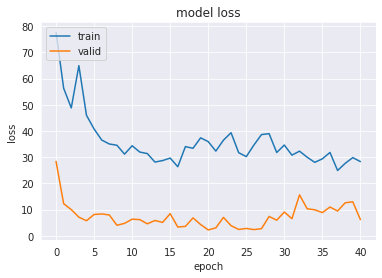

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [24]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [25]:
poly_optimize

<tf.Tensor: shape=(36,), dtype=float32, numpy=
array([0.0000000e+00, 1.0000000e+00, 2.0000000e+00, 2.8698709e-05,
       7.8011173e-05, 2.1205636e-04, 5.7642895e-04, 1.5668964e-03,
       4.2592660e-03, 1.1577886e-02, 3.1471953e-02, 8.5549638e-02,
       2.3254804e-01, 6.3213110e-01, 2.8698709e-05, 7.8011173e-05,
       2.1205636e-04, 5.7642895e-04, 1.5668964e-03, 4.2592660e-03,
       1.1577886e-02, 3.1471953e-02, 8.5549638e-02, 2.3254804e-01,
       6.3213110e-01, 2.8698709e-05, 7.8011173e-05, 2.1205636e-04,
       5.7642895e-04, 1.5668964e-03, 4.2592660e-03, 1.1577886e-02,
       3.1471953e-02, 8.5549638e-02, 2.3254804e-01, 6.3213110e-01],
      dtype=float32)>

In [26]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [27]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 166)]        0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          85504       input[0][0]                      
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
hidden2_1024 (Dense)            (None, 1024)         525312      dropout1_0.25[0][0]              
______________________________________________________________________________________________

In [28]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [29]:
scores_test_list[-1].index

Index(['lambda_preds_VS_target_polynomials',
       'lambda_preds_VS_lstsq_lambda_pred_polynomials',
       'lambda_preds_VS_lstsq_target_polynomials',
       'lambda_preds_VS_inet_polynomials',
       'lambda_preds_VS_symbolic_regression_functions',
       'lambda_preds_VS_per_network_polynomials',
       'target_polynomials_VS_lstsq_lambda_pred_polynomials',
       'target_polynomials_VS_lstsq_target_polynomials',
       'target_polynomials_VS_inet_polynomials',
       'target_polynomials_VS_symbolic_regression_functions',
       'target_polynomials_VS_per_network_polynomials',
       'lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials',
       'lstsq_lambda_pred_polynomials_VS_inet_polynomials',
       'lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions',
       'lstsq_lambda_pred_polynomials_VS_per_network_polynomials',
       'lstsq_target_polynomials_VS_inet_polynomials',
       'lstsq_target_polynomials_VS_symbolic_regression_functions',
       'lstsq_target_p

In [30]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,119604850605.702,3373729988610.452,698254998122.887,-2534290057441034669136019456.000,1016241863728.340,516083394344291.312,3371545220396.547,-0.643,-20464940957.314,8.296,5703273741976.224
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,94504.770,2610384.820,414723.244,-6320774120784928.000,969968.265,375276154.895,2608635.637,-0.643,49758.070,8.296,8237850.289
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,119604850605.702,3373729988610.444,698254998122.887,-2534290057441028072066252800.000,1016241863728.338,516083394344291.250,3371545220396.540,-0.643,-20464940957.314,8.296,5703273741976.212
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,188364.986,5064050.934,1738813.982,-35939066570228348.000,2064315.183,340006419.475,5060418.730,-0.643,84699.820,8.296,12107456.802
lambda_preds_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,0.078,1.235,0.151,0.660,0.154,0.252,1.231,-0.643,-0.606,8.296,14.760
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,3336.564,84417.292,291.549,-608378761.564,163.005,94169.518,84351.323,-0.643,3313.776,8.296,841002.959
target_polynomials_VS_lstsq_lambda_pred_polynomials,2.730,11.703,95.719,0.023,0.000,119604891345.826,3373731004725.254,1.765,-0.002,0.039,16.102,3371546235691.990,-20464940957.314,49758.070,5703273741976.224,8237850.289
target_polynomials_VS_lstsq_target_polynomials,0.090,0.200,6.212,0.664,0.060,0.002,0.012,0.001,1.000,0.000,0.000,0.012,-20464940957.314,-20464940957.314,5703273741976.224,5703273741976.212
target_polynomials_VS_inet_polynomials,0.511,0.585,1.892,0.040,0.000,119604847033.000,3373730008843.604,1.033,-0.001,0.039,16.098,3371545240806.303,-20464940957.314,84699.820,5703273741976.224,12107456.802
target_polynomials_VS_symbolic_regression_functions,NaN,NaN,NaN,NaN,NaN,119604850605.737,3373729988610.462,1.975,-0.002,0.039,16.102,3371545220396.557,-20464940957.314,-0.606,5703273741976.224,14.760


In [31]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,82491592140.251,47842111198.531,724804163.436,6310926694.002,25239337277.466,3539077137.404,542609926897.508,30063281087.242,256299759702.522,11958431763.912,89535598913.640,1073061208.430,902847618.989,57425765464.457,85763363750.729,411681142023.226,100061887648.439,4197036457.714,1321353731.588,1365293105.497,36431921.204,166687123784.439,566821949194.867,34568089721.766,375834781938.207,535280704.936,2011485315.106,8149034302.939,139589599253.728,256467313362.018,198085960612.191,85474126944.381,23686732968.066,723592894.954,41430605066.233,12554049192.911,60958656972.315,520313851579.627,48103814827.547,26604238420.712,569572131006.648,26924152905.832,708886267286.101,1962291817.707,2658807884.651,107227354857.215,37351689175.169,11295136766.347,24364733754.431,17564754755.896,36461039089.153,157915506502.902,332950424619.206,222228754641.621,16467078542.758,191121621963.509,511242925769.201,32100512890.442,45798710434.061,1723150506.039,77841313915.734,303414397066.639,4225021901.530,144746032525.518,91425448735.718,98683330954.303,153550898480.672,366319580719.853,369575446047.521,97540454848.696,21740938180.142,38974735387.783,36176121153.137,8553796561.427,6197427916.368,137825533234.474,92645793941.450,34967564799.495,25503172770.543,102351954623.719,33013847656.056,313978855.311,81502892953.670,113392571563.194,67556735317.216,81251788378.719,69932253100.007,183220135067.323,74848440703.369,7115918032.011,85086616670.502,36291239527.745,561931725484.113,311655575874.913,61881743279.792,40716849082.308,107568178378.690,25387102302.042,6258995.213,420691883451.243
lambda_preds_VS_lstsq_lambda_pred_polynomials,87456.341,50481.159,1508.175,3045.380,42831.044,857.626,114734.695,22470.798,32205.068,18412.928,150084.711,407.327,22998.449,12397.706,227132.775,149310.991,19071.684,15498.308,382.288,435.717,62.785,25780.479,172719.822,9643.932,124335.684,893.515,793.905,1810.468,38626.529,115052.099,88235.555,103815.019,10611.703,361.113,17580.884,3215.330,37247.620,148976.341,17604.782,9549.238,66579.219,1052.178,16212.347,284.528,228.141,115679.189,22016.644,7531.380,5007.251,4960.557,9798.511,47041.066,259933.527,277452.005,3766.330,36586.820,242588.414,7328.652,15499.986,998.722,423078.098,126589.208,5408.119,45814.944,94446.822,23442.328,42311.832,51460.545,252556.074,94875.818,7926.781,9529.216,6513.389,2019.697,1496.543,91994.539,212721.987,7653.219,16544.621,3018257.788,83146.300,2985.171,190039.314,30783.453,15640.627,102750.524,30607.464,170222.246,152043.975,4043.626,182226.277,24518.567,152832.850,161083.775,17295.085,8551.735,46174.631,13703.198,15.404,487985.815
lambda_preds_VS_lstsq_target_polynomials,82491592140.251,47842111198.531,724804163.436,6310926694.002,25239337277.467,3539077137.404,542609926897.508,30063281087.235,256299759702.505,11958431763.912,89535598913.640,1073061208.430,902847618.989,57425765464.457,85763363750.729,411681142023.226,100061887648.439,4197036457.714,1321353731.588,1365293105.497,36431921.204,166687123784.441,566821949194.866,34568089721.766,375834781938.207,535280704.936,2011485315.106,8149034302.939,139589599253.729,256467313362.018,198085960612.191,85474126944.382,23686732968.066,723592894.954,41430605066.234,12554049192.911,60958656972.315,520313851579.627,48103814827.547,26604238420.712,569572131006.646,26924152905.831,708886267286.100,1962291817.707,2658807884.657,107227354857.215,37351689175.169,11295136766.348,24364733754.431,17564754755.895,36461039089.153,

In [32]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
lambda_preds_VS_target_polynomials,-645888423851669971040993280.000,-48843385714890481611046912.000,-23129919088429671383040.000,-826174960426442628792320.000,-258287214638733832010858496.000,-735830451373352559837184.000,-11831101525101929698443657216.000,-80905522646610068119748608.000,-3520083954161624314946781184.000,-6367655890472399957655552.000,-553492266681969387432312832.000,-21954165577829457068032.000,-40029942161859453911040.000,-116266184476658002022105088.000,-35082635259578156186968522752.000,-3583320890633177639721893888.000,-233261017613349497878872064.000,-940730178655979336368128.000,-27156464172374744367104.000,-63960750737218160558080.000,-23515327509127528448.000,-2189362967650045483066327040.000,-8227171905845873109479981056.000,-75441321244335442881413120.000,-3413322270592049147029749760.000,-14886641689701897994240.000,-109630960188468423032832.000,-4133229035283394546630656.000,-910183727156105272998494208.000,-2945124596631679039419973632.000,-2496810467360528013736280064.000,-396375487888358453001846784.000,-17913834532234718185783296.000,-12120587568339065241600.000,-85697130181996694007185408.000,-2880857031012152713936896.000,-145728617196383257648693248.000,-17470859214040357089260339200.000,-59394003845682987467276288.000,-16500986945435763751256064.000,-20061808846353238334040440832.000,-18522047904513098862559232.000,-36870169914923258619436728320.000,-114682320521724377956352.000,-699046880533732814487552.000,-713673009049168285003677696.000,-49094492408391357951901696.000,-5803929770908341495660544.000,-19736513772591802117783552.000,-11414974892685882858405888.000,-43286588556657477443125248.000,-1472137917620015120204693504.000,-3340388841378086972364423168.000,-1300423102485084751309832192.000,-11508268183603441980932096.000,-3634018429881113225354805248.000,-5836450364718952555963482112.000,-19894472299959381978513408.000,-63945100549333073969283072.000,-55562811024162567487488.000,-1854618370578133352779350016.000,-2243378781406027061076688896.000,-1026735659394396237856768.000,-1216628151983947893599895552.000,-351721398688828341039923200.000,-518166673828997832007221248.000,-584922146687413567837175808.000,-7127894195850171642898546688.000,-413831683059417496726536192.000,-868558991791239396071571456.000,-21812817271832205802340352.000,-34719199700886999550394368.000,-33521805993441478211272704.000,-1742840676362662457638912.000,-751822979513367683661824.000,-546979084007524341718712320.000,-295187721452494902555312128.000,-60993733456563009788837888.000,-37543609064227002428424192.000,-268760871613823497508225024.000,-29136849295576597121728512.000,-11358637570302488346624.000,-312582142414591564464521216.000,-433039302200577576759459840.000,-224135216480332501487714304.000,-323002503661302042597523456.000,-129008579739879049510518784.000,-12148959647024960541825171456.000,-356762931238439446063874048.000,-2561213235451427251290112.000,-367072304714383391255953408.000,-86301727017413724967272448.000,-9388412728577375947659935744.000,-5194460296844595860751777792.000,-65504621954773440842956800.000,-87129620578923536818634752.000,-799223806331290105749176320.000,-31667397827947790075953152.000,-2536559563233.093,-39073957207114651575674470400.000
lambda_preds_VS_lstsq_lambda_pred_polynomials,-730820284665401.750,-55573936750527.383,-106235783134.437,-200903240219.670,-755205109361854.125,-45664970426.832,-537936342463948.812,-46007922381574.352,-57005811452243.703,-15524125649276.029,-1564399503534138

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-0.0015453458104599527


0.011922269128263*a**5 - 0.0282679256051779*a**4 + 0.00281487149186432/a**4

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.23437968635472672


-1.4931038889823*a**5 + 5.87759875284545*a**4 - 9.57755753980411*a**3 + 8.39339036771252*a**2 - 4.28008512133884*a + 1.1559846051358 - 0.245902763024513/a + 0.0262742802555203/a**2 - 0.0015458934213282/a**3 + 4.69135447835334e-5/a**4 - 5.73643965218196e-7/a**5

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.893911393359995*a**5 + 0.776586595020089*a**4 - 0.384002075811796*a**3 + 0.446127467106373*a**2 + 0.478146341253517*a + 0.860447468783204 + 0.864525873084074/a - 0.92239394695123/a**2 + 0.208701272608043/a**3 + 0.28645021145059/a**4 - 0.409869679566993/a**5

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.015188603903235398


0.160032913088799*a**3 - 0.171034067869186/a**2 + 0.526858866214752/a**3

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-0.00028779788340793644


-0.0008046827096942*a**5 + 0.0036758076661226*a**4 - 0.0070696454800957*a**3 + 0.0073130178034664*a**2 + 216.991064491395*a - 163.22134853087 - 0.0003172012211275/a + 3.83337780149734e-5/a**2 - 2.66109214885901e-6/a**3 + 9.76894458659672e-8/a**4 - 1.46144429891137e-9/a**5

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.114125756531128*a**5 + 0.891259355497994*a**4 + 0.141122809249213*a**3 + 0.357094682836321*a**2 + 0.919833379284182*a + 0.477556057837195 + 0.198587132620957/a - 0.0473234130112676/a**2 + 0.865692442720598/a**3 - 0.847830546468985/a**4 + 0.0022394016506963/a**5

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.00136786879539325 (100 Samples)
Mean (only positive): 0.015188603903235398 (1 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -0.0015355589931391146 (100 Samples)
Mean (only positive): nan (0 Samples)


<AxesSubplot:xlabel='target_polynomials_VS_inet_polynomials', ylabel='Count'>

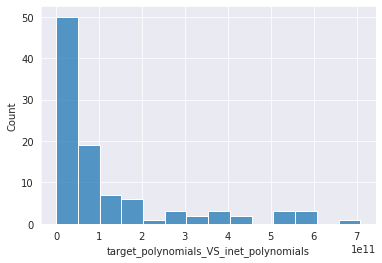

In [41]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50])


<AxesSubplot:xlabel='target_polynomials_VS_lstsq_lambda_pred_polynomials', ylabel='Count'>

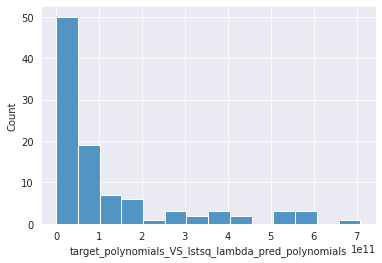

In [42]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50])


[(-30.0, 1.0)]

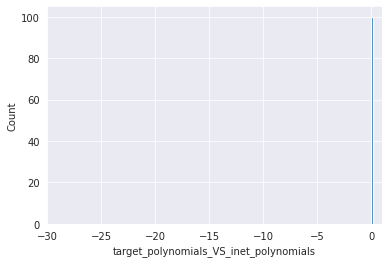

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

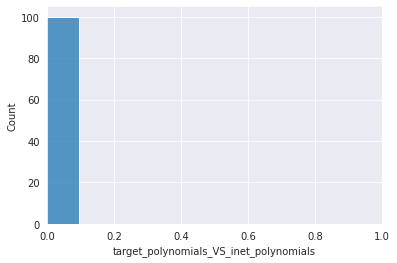

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

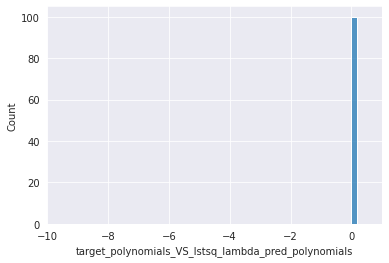

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

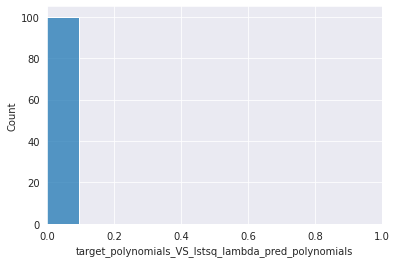

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

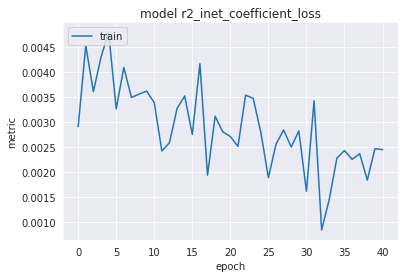

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


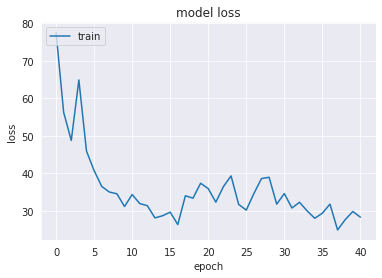

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.3805*a**5 - 1.472*a**4 + 2.4237*a**3 - 2.2418*a**2 + 0.8075*a - 0.6951 + 0.092/a - 0.0093/a**2 + 0.0005/a**3

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.5531*a**5 + 0.4423*a**4 + 0.4972*a**3 + 0.416*a**2 - 0.7053*a + 0.8454 + 0.6093/a - 0.5753/a**2 + 0.1109/a**3 - 0.7804/a**4 - 0.8185/a**5

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.4967*a**5 + 0.4789*a**4 + 0.6126*a**3 + 0.2659*a**2 - 0.6433*a + 0.835 + 0.61/a - 0.5753/a**2 + 0.1109/a**3 - 0.7804/a**4 - 0.8185/a**5

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.0148000000044703*a**5 - 0.0205000005662441*a**4 - 0.000300000014249235/a**4

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-0.507*x - 0.21

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
per_network_polynomials


-0.474700003862381*a - 0.240299999713898 + 0.000300000014249235/a**2

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


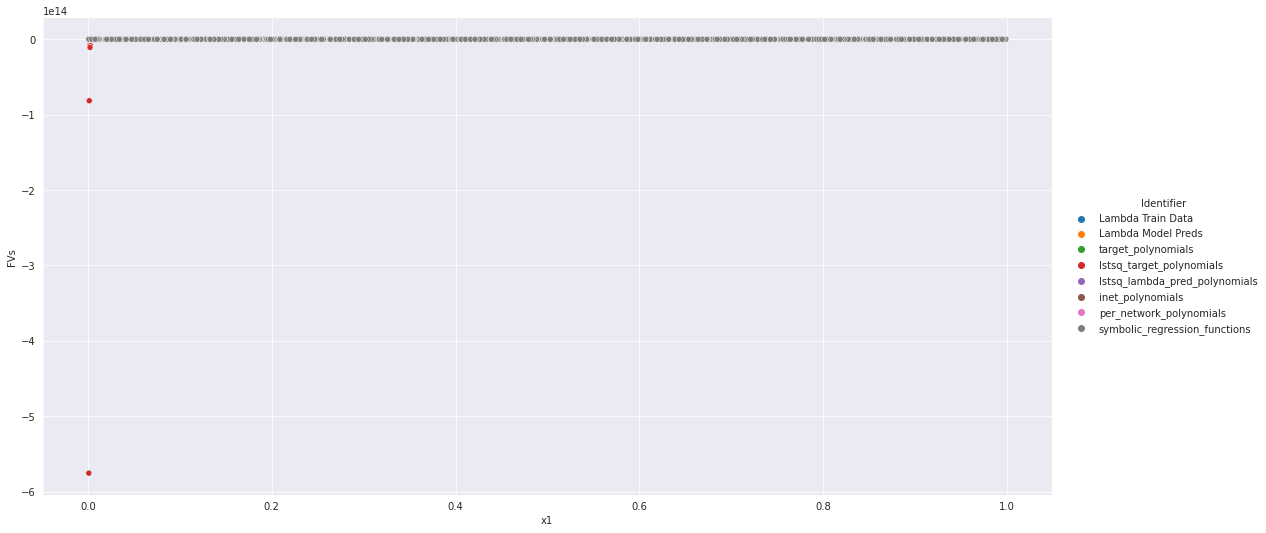

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

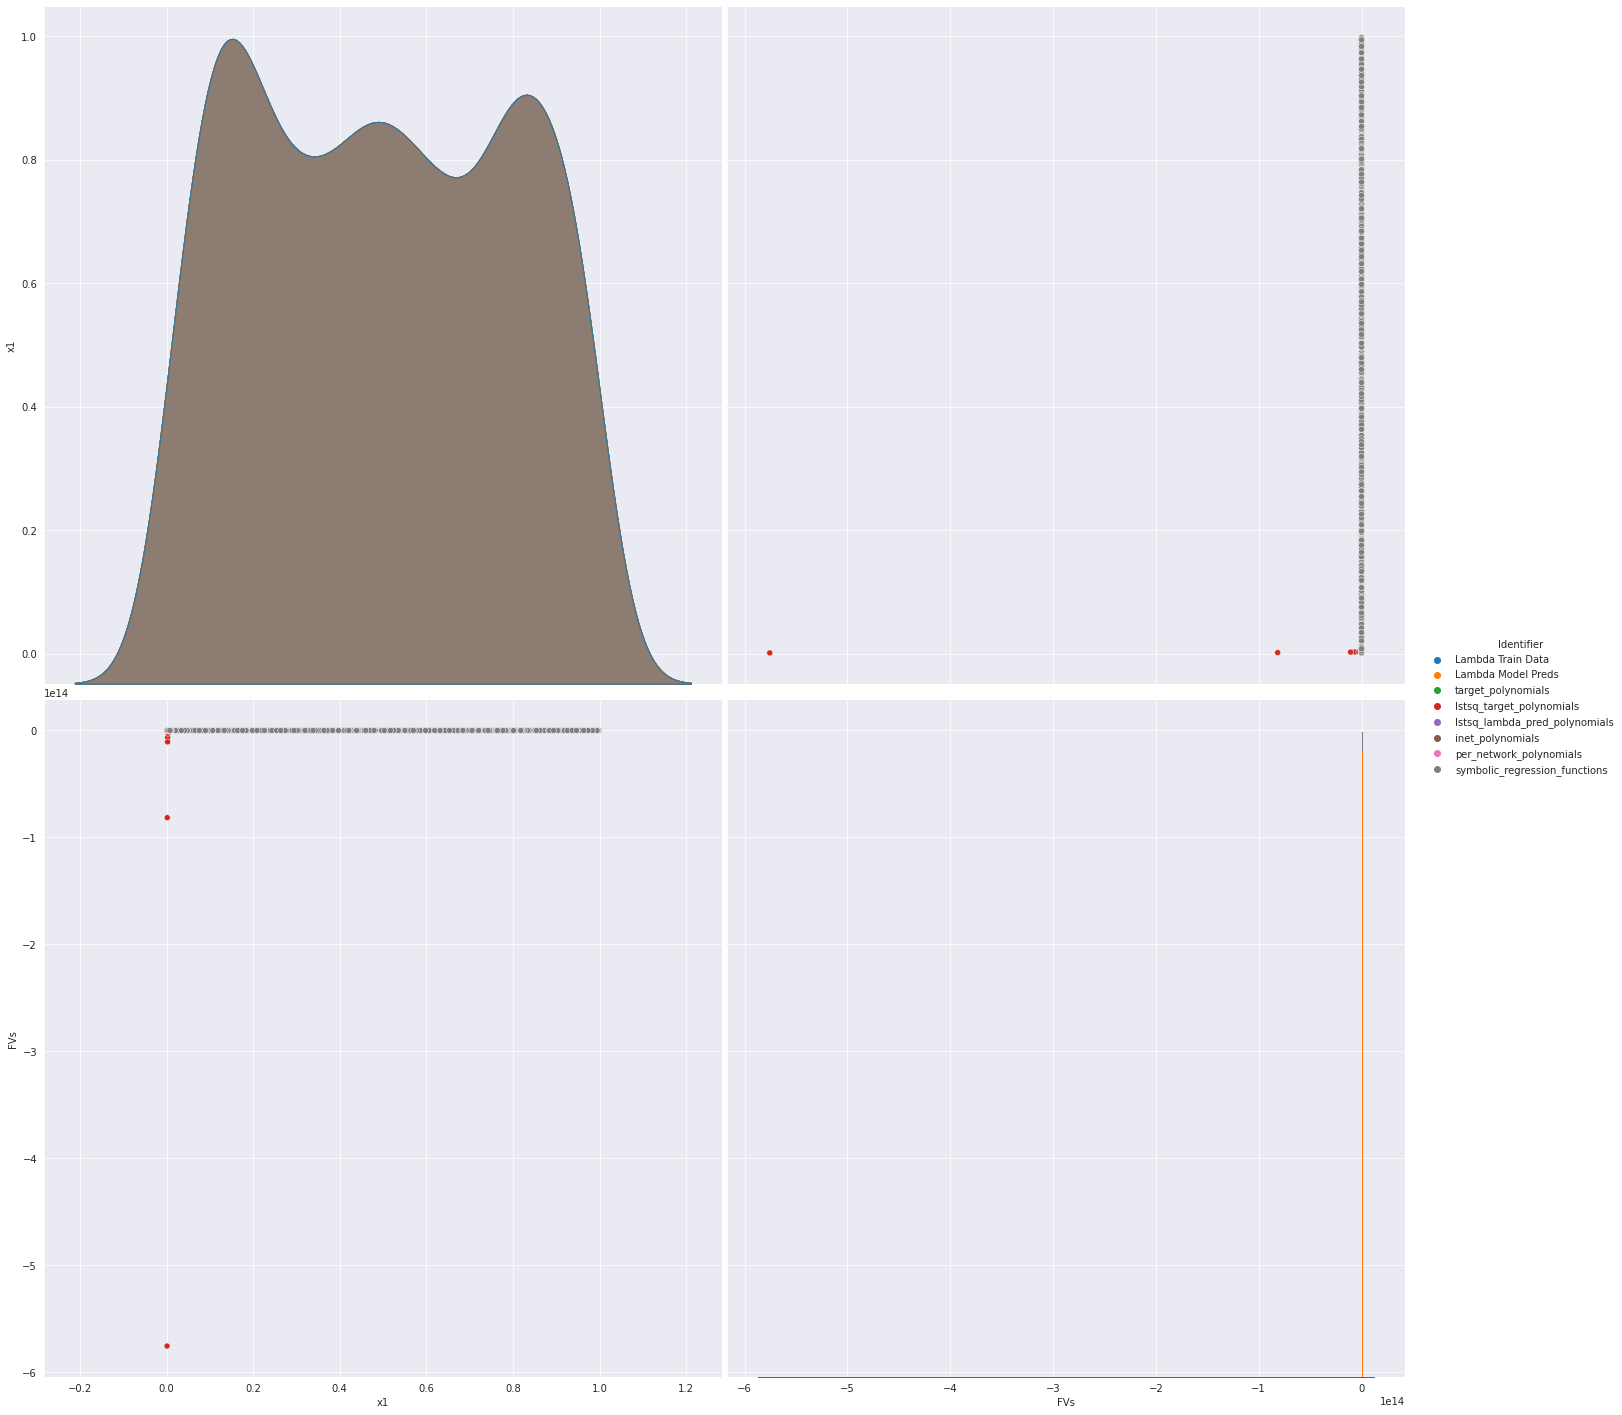

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

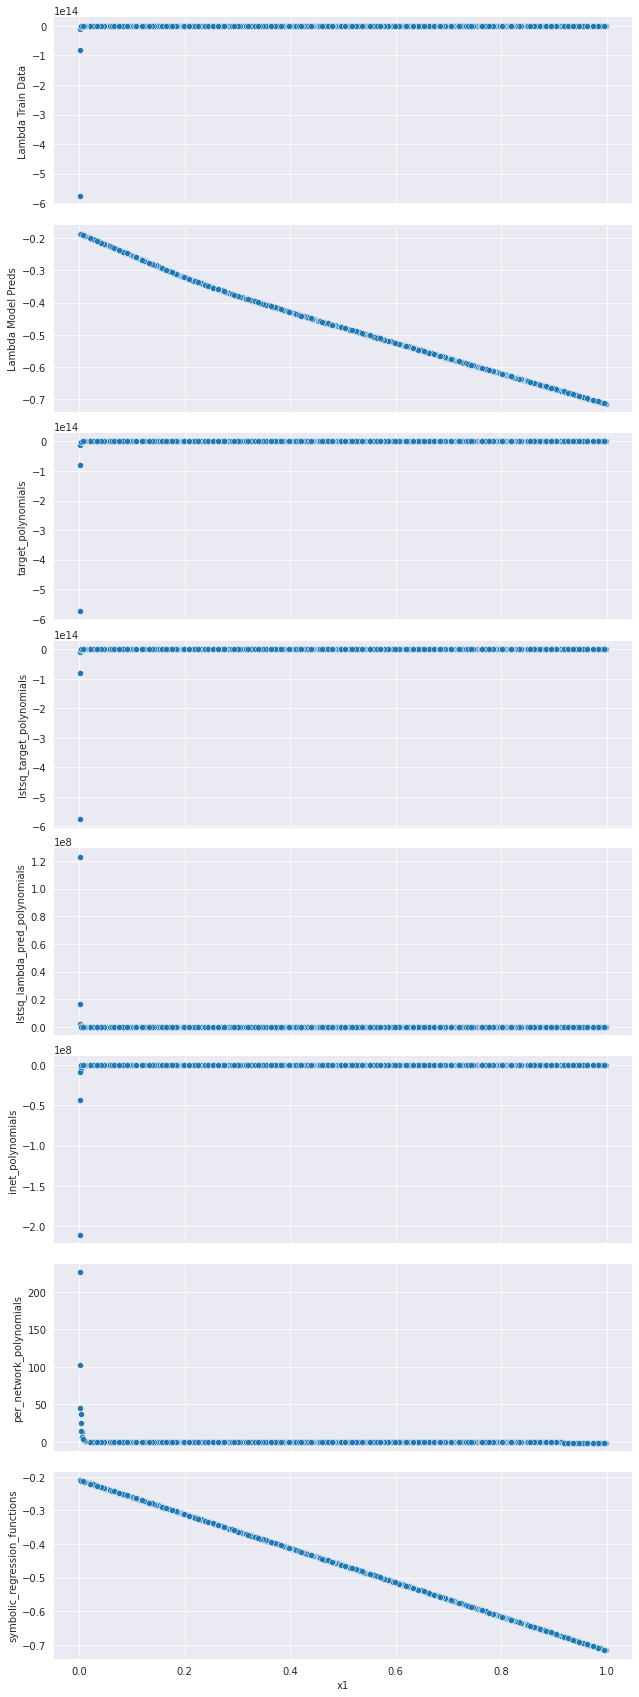

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.056


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 1275476886855.825


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 139895559156.5873


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 520.2664184570312 
 Curr_res: 2931.877685546875 
 Iteration 1, Step 22
Optimization terminated at 8.142006874084473


array([-0.00267631,  0.21313582, -0.13563791,  0.9118674 ,  0.637642  ,
        0.18209696,  0.63791955,  0.27701473,  0.04227114,  0.84219384,
        0.90637195,  0.222556  ,  0.9198462 ,  0.68789077,  0.42705178,
        0.878158  ,  0.6943959 ,  0.46567595,  0.52925766,  0.33019018,
        0.12754858,  0.16153514,  0.5085137 ,  0.44301772,  0.35205877,
        0.8969147 ,  0.24940813,  0.76328313,  0.85935795,  0.08480155,
        0.20418596,  0.28848922,  0.65142167,  0.7106751 ,  0.8695041 ,
        0.23745108], dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [64]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == train_features_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

,Horsepower
0,0.457
1,0.647
2,0.565
3,0.565
4,0.511


In [66]:
#%load_ext autoreload

In [71]:
np.isinf(features_autoMPG_model.values).any()

False

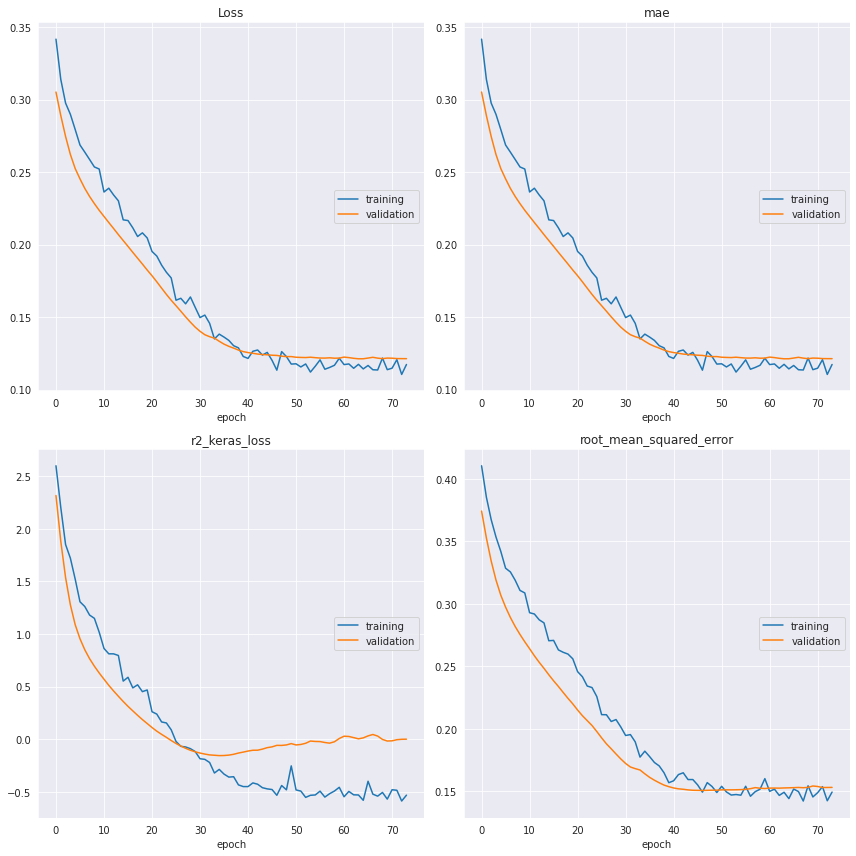

Loss
	training         	 (min:    0.110, max:    0.342, cur:    0.117)
	validation       	 (min:    0.121, max:    0.305, cur:    0.121)
mae
	training         	 (min:    0.110, max:    0.342, cur:    0.117)
	validation       	 (min:    0.121, max:    0.305, cur:    0.121)
r2_keras_loss
	training         	 (min:   -0.587, max:    2.600, cur:   -0.531)
	validation       	 (min:   -0.155, max:    2.317, cur:    0.001)
root_mean_squared_error
	training         	 (min:    0.142, max:    0.411, cur:    0.149)
	validation       	 (min:    0.151, max:    0.374, cur:    0.153)


In [79]:
%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[42], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

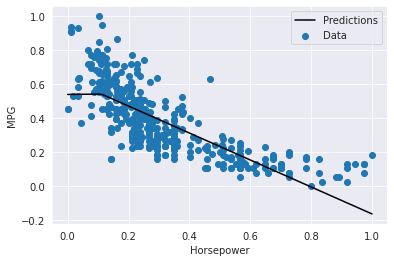

In [80]:
if interpretation_possible_autoMPG:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [81]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [82]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


0.506439839276527*a**5 + 0.458226487934362*a**4 + 0.527423488924102*a**3 + 0.541859656059251*a**2 + 0.333555005788691*a + 0.531166052399797 + 0.0964157001365321/a + 0.506439839276527/a**2 + 0.419516499441168/a**3 - 738.507382325774/a**4 + 0.0101845241838812/a**5

MAE Model:  7.598212165069248
MAE Data:  7.69251379833596
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [83]:
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


0.0201080814003944*a**5 - 0.0361625552177429/a**2

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [84]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 21.054718017578125 
 Curr_res: 21.054718017578125 
 Iteration 2, Step 141
Optimization terminated at 10.971325874328613
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.101641371846199*a - 0.311533182859421 + 0.0039161778986454/a**4

MAE Model:  1.834380749859506e+306
MAE Data:  1.834380749859506e+306
Computation Time: 0:00:16
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [85]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81          2430.55       15        0.0314037         0.030038      7.19m
   1    11.02          1.58732        7        0.0265116        0.0269929      3.04m
   2     6.95         0.744974       13        0.0132895        0.0125904      2.57m
   3     5.82         0.643089       13        0.0131113        0.0141944      2.32m
   4     3.57         0.510909        7        0.0193187         0.023762      2.13m
   5     3.45         0.522992        5        0.0339587        0.0331326      2.06m
   6     3.37         0.384807        3         0.049247        0.0661374      1.82m
   7     3.40          0.78191        3        0.0495804        0.0631366      1.67m
   8     3.43          2.35758        5        0.0457991        0.0495486  

0.743 - 0.981*x

MAE Model:  0.06259838169955954
MAE Data:  0.1268539487719232
Computation Time: 0:03:19
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [86]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [87]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [88]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


0.0201080814003944*a**5 - 0.0361625552177429/a**2

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.101641371846199*a - 0.311533182859421 + 0.0039161778986454/a**4

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-0.340119925360958*a**5 + 1.80842674523318*a**4 - 3.88309524837479*a**3 + 4.44109775203431*a**2 - 3.77542856780848*a + 1.84915945038341 - 0.303276473109253/a + 0.0448912752771039/a**2 - 0.00373959286618311/a**3 + 0.000157391026496922/a**4 - 2.59814055425522e-6/a**5

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


0.743 - 0.981*x

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


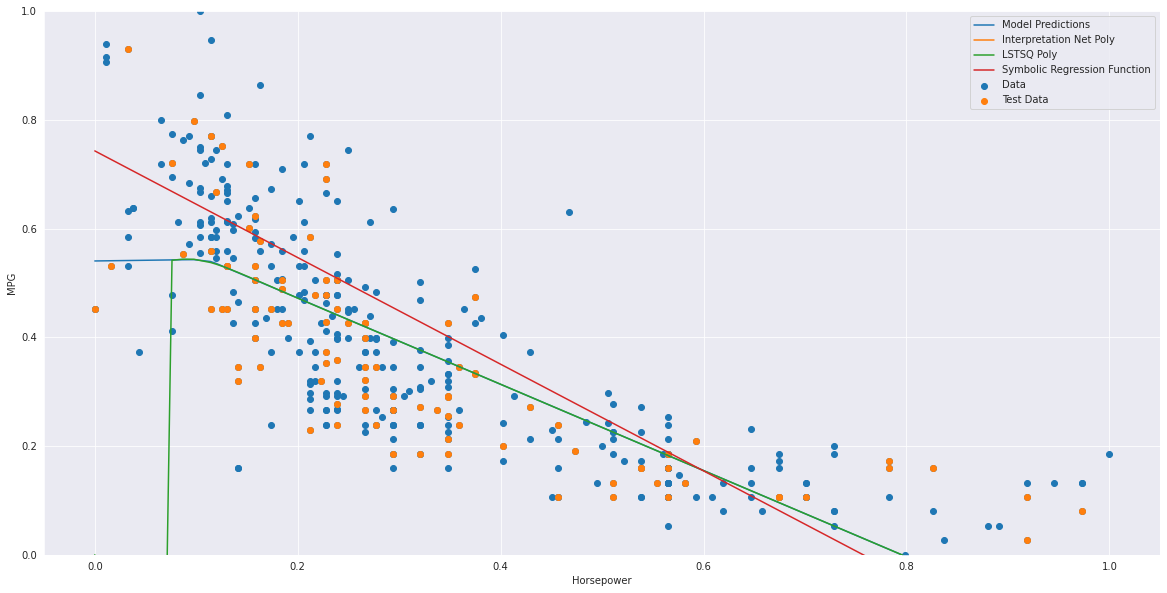

In [124]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,1])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()